In [1]:
import numpy as np
import mne
from mne_connectivity import spectral_connectivity_epochs
from spectral_connectivity import Multitaper, Connectivity
import dynsys_orig as dynsys
import seaborn as sns
from matplotlib import pyplot as plt
import PRA as pra

In [2]:
#v1
sfreq = 100 # Hz
tmin = 0 # s
tmax = 100 # s
time = np.arange(tmin, tmax, 1/sfreq) 

c_1_2 = 1
c_3_1 = 1
c_3_2 = 1

f1 = 0.125
f2 = 0.25
f3 = 0.10

signal1 = np.sin(2*np.pi*f1*time)
signal2 = np.sin(2*np.pi*f2*time)
signal3 = np.sin(2*np.pi*f3*time)

snr1 = 0.01
snr2 = 0.01
snr3 = 0.01

noise1 = np.random.randn(len(time))
noise2 = np.random.randn(len(time))
noise3 = np.random.randn(len(time))

phase_1 = 0.5*np.pi
phase_2 = np.pi
phase_3 = 0.25*np.pi

lag1 = np.int64((phase_1/(2*np.pi)*sfreq))
lag2 = np.int64((phase_2/(2*np.pi)*sfreq))
lag3 = np.int64((phase_3/(2*np.pi)*sfreq))

#### y3, y2 present

In [3]:
y3 = signal3 + noise3*snr3 
y1 = signal1 + noise1*snr1 + c_3_1*np.roll(y3, lag1)
y2 = signal2 + noise2*snr2 + c_3_2*np.roll(y3, lag2) + c_1_2*np.roll(y1, lag3)

In [4]:
## simulated data
sim_data = np.array([y1,y2,y3])
info = mne.create_info(ch_names=["y1", "y2", "y3"], ch_types=["eeg"]*3, sfreq=100)
simulated_raw = mne.io.RawArray(sim_data, info)
epochs = mne.make_fixed_length_epochs(simulated_raw, duration=10)

## estimations
#dynsys
epoch_idx = np.arange(1)
region = ['y1','y2','y3']
dynsys_mat,cond_num,mse,snr = dynsys.dynSys(epochs.get_data(), epoch_idx, region, sampling_time=0.01)

#coh 
mne_con = spectral_connectivity_epochs(epochs, method='coh', sfreq=sfreq, fmin=8, fmax=13, fskip=0, faverage=False,
                                      mt_low_bias=True, block_size=1000, n_jobs=1, verbose=None)
coh_mat = mne_con.get_data(output="dense")

#ciplv
mne_con = spectral_connectivity_epochs(epochs, method='ciplv', sfreq=sfreq, fmin=8, fmax=13, fskip=0, faverage=False,
                                      mt_low_bias=True, block_size=1000, n_jobs=1, verbose=None)
ciplv_mat = mne_con.get_data(output="dense")

#gpdc
m = Multitaper(time_series=np.array(epochs.get_data()).transpose(2, 0, 1), sampling_frequency=100)
c = Connectivity(fourier_coefficients=m.fft(), frequencies=m.frequencies, time=m.time)    
con = getattr(c, 'generalized_partial_directed_coherence')()
gpdc_mat = np.nan_to_num(con.squeeze())[80:131].transpose(1,2,0)

#ddtf
m = Multitaper(time_series=np.array(epochs.get_data()).transpose(2, 0, 1), sampling_frequency=100)
c = Connectivity(fourier_coefficients=m.fft(), frequencies=m.frequencies, time=m.time)    
con = getattr(c, 'direct_directed_transfer_function')()
ddtf_mat = np.nan_to_num(con.squeeze())[80:131].transpose(1,2,0)

#psgp
m = Multitaper(time_series=np.array(epochs.get_data()).transpose(2, 0, 1), sampling_frequency=100)
c = Connectivity(fourier_coefficients=m.fft(), frequencies=m.frequencies, time=m.time)    
con = getattr(c, 'pairwise_spectral_granger_prediction')()
psgp_mat = np.nan_to_num(con.squeeze())[80:131].transpose(1,2,0)

#pra
epoch_idx = np.arange(1)
region = ['y1','y2','y3']
pra_mat = pra.PRA(epochs.get_data())

Creating RawArray with float64 data, n_channels=3, n_times=10000
    Range : 0 ... 9999 =      0.000 ...    99.990 secs
Ready.
Not setting metadata
10 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 10 events and 1000 original time points ...
0 bad epochs dropped


  0%|          | 0/10 [00:00<?, ?it/s]

Adding metadata with 3 columns
Connectivity computation...
only using indices for lower-triangular matrix
    computing connectivity for 3 connections
    using t=0.000s..9.990s for estimation (1000 points)
    frequencies: 8.0Hz..13.0Hz (51 points)
    Using multitaper spectrum estimation with 7 DPSS windows
    the following metrics will be computed: Coherence
    computing connectivity for epoch 1
    computing connectivity for epoch 2
    computing connectivity for epoch 3
    computing connectivity for epoch 4
    computing connectivity for epoch 5
    computing connectivity for epoch 6
    computing connectivity for epoch 7
    computing connectivity for epoch 8
    computing connectivity for epoch 9
    computing connectivity for epoch 10
    assembling connectivity matrix
[Connectivity computation done]
Replacing existing metadata with 3 columns
Connectivity computation...
only using indices for lower-triangular matrix
    computing connectivity for 3 connections
    using t=0.

  0%|          | 0/10 [00:00<?, ?it/s]

In [5]:
## heatmaps

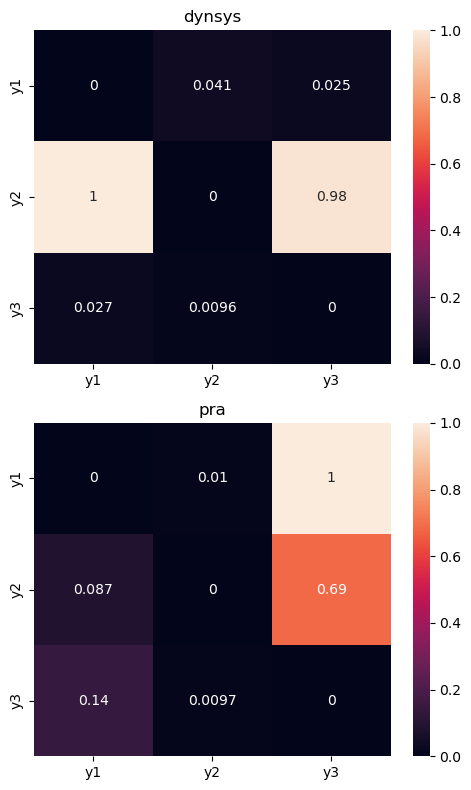

In [6]:
fig, (ax1,ax2) = plt.subplots(2,1,figsize=(5,8))
sns.heatmap(dynsys_mat.squeeze(), annot=True, xticklabels=['y1','y2','y3'], yticklabels=['y1','y2','y3'], ax=ax1)
ax1.set_title('dynsys')

sns.heatmap(pra_mat, annot=True, xticklabels=['y1','y2','y3'], yticklabels=['y1','y2','y3'], ax=ax2)
ax2.set_title('pra')

fig.tight_layout()
plt.savefig('heatmaps.png')

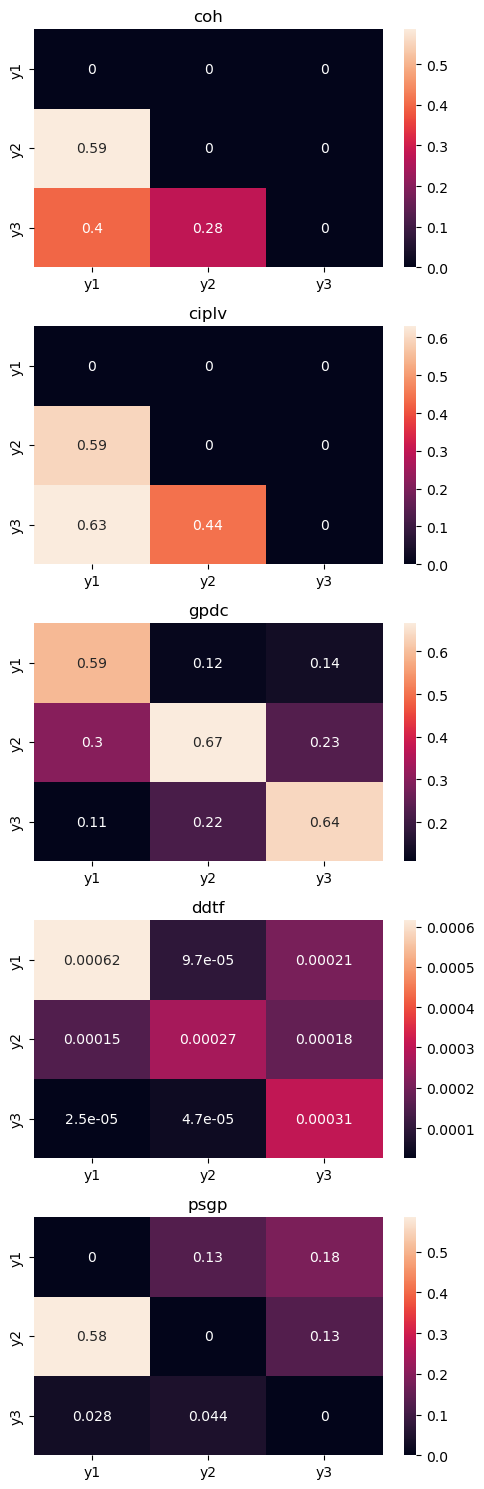

In [7]:
fig, (ax1,ax2,ax3,ax4,ax5) = plt.subplots(5,1,figsize=(5,15))
sns.heatmap(coh_mat.mean(2), annot=True, xticklabels=['y1','y2','y3'], yticklabels=['y1','y2','y3'], ax=ax1)
ax1.set_title('coh')

sns.heatmap(ciplv_mat.mean(2), annot=True, xticklabels=['y1','y2','y3'], yticklabels=['y1','y2','y3'], ax=ax2)
ax2.set_title('ciplv')

sns.heatmap(gpdc_mat.mean(2), annot=True, xticklabels=['y1','y2','y3'], yticklabels=['y1','y2','y3'], ax=ax3)
ax3.set_title('gpdc')

sns.heatmap(ddtf_mat.mean(2), annot=True, xticklabels=['y1','y2','y3'], yticklabels=['y1','y2','y3'], ax=ax4)
ax4.set_title('ddtf')

sns.heatmap(psgp_mat.mean(2), annot=True, xticklabels=['y1','y2','y3'], yticklabels=['y1','y2','y3'], ax=ax5)
ax5.set_title('psgp')
fig.tight_layout()
plt.savefig('heatmaps.png')

#### y3, y2 not present

In [8]:
y3 = signal3 + noise3*snr3 
y1 = signal1 + noise1*snr1 + c_3_1*np.roll(y3, lag1)
y2 = signal2 + noise2*snr2 + c_1_2*np.roll(y1, lag3)

In [9]:
## simulated data
sim_data = np.array([y1,y2,y3])
info = mne.create_info(ch_names=["y1", "y2", "y3"], ch_types=["eeg"]*3, sfreq=100)
simulated_raw = mne.io.RawArray(sim_data, info)
epochs = mne.make_fixed_length_epochs(simulated_raw, duration=10)

## estimations
#dynsys
epoch_idx = np.arange(1)
region = ['y1','y2','y3']
dynsys_mat,cond_num,mse,snr = dynsys.dynSys(epochs.get_data(), epoch_idx, region, sampling_time=0.01)

#coh 
mne_con = spectral_connectivity_epochs(epochs, method='coh', sfreq=sfreq, fmin=8, fmax=13, fskip=0, faverage=False,
                                      mt_low_bias=True, block_size=1000, n_jobs=1, verbose=None)
coh_mat = mne_con.get_data(output="dense")

#ciplv
mne_con = spectral_connectivity_epochs(epochs, method='ciplv', sfreq=sfreq, fmin=8, fmax=13, fskip=0, faverage=False,
                                      mt_low_bias=True, block_size=1000, n_jobs=1, verbose=None)
ciplv_mat = mne_con.get_data(output="dense")

#gpdc
m = Multitaper(time_series=np.array(epochs.get_data()).transpose(2, 0, 1), sampling_frequency=100)
c = Connectivity(fourier_coefficients=m.fft(), frequencies=m.frequencies, time=m.time)    
con = getattr(c, 'generalized_partial_directed_coherence')()
gpdc_mat = np.nan_to_num(con.squeeze())[80:131].transpose(1,2,0)

#ddtf
m = Multitaper(time_series=np.array(epochs.get_data()).transpose(2, 0, 1), sampling_frequency=100)
c = Connectivity(fourier_coefficients=m.fft(), frequencies=m.frequencies, time=m.time)    
con = getattr(c, 'direct_directed_transfer_function')()
ddtf_mat = np.nan_to_num(con.squeeze())[80:131].transpose(1,2,0)

#psgp
m = Multitaper(time_series=np.array(epochs.get_data()).transpose(2, 0, 1), sampling_frequency=100)
c = Connectivity(fourier_coefficients=m.fft(), frequencies=m.frequencies, time=m.time)    
con = getattr(c, 'pairwise_spectral_granger_prediction')()
psgp_mat = np.nan_to_num(con.squeeze())[80:131].transpose(1,2,0)

#pra
epoch_idx = np.arange(1)
region = ['y1','y2','y3']
pra_mat = pra.PRA(epochs.get_data())

Creating RawArray with float64 data, n_channels=3, n_times=10000
    Range : 0 ... 9999 =      0.000 ...    99.990 secs
Ready.
Not setting metadata
10 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 10 events and 1000 original time points ...
0 bad epochs dropped


  0%|          | 0/10 [00:00<?, ?it/s]

Adding metadata with 3 columns
Connectivity computation...
only using indices for lower-triangular matrix
    computing connectivity for 3 connections
    using t=0.000s..9.990s for estimation (1000 points)
    frequencies: 8.0Hz..13.0Hz (51 points)
    Using multitaper spectrum estimation with 7 DPSS windows
    the following metrics will be computed: Coherence
    computing connectivity for epoch 1
    computing connectivity for epoch 2
    computing connectivity for epoch 3
    computing connectivity for epoch 4
    computing connectivity for epoch 5
    computing connectivity for epoch 6
    computing connectivity for epoch 7
    computing connectivity for epoch 8
    computing connectivity for epoch 9
    computing connectivity for epoch 10
    assembling connectivity matrix
[Connectivity computation done]
Replacing existing metadata with 3 columns
Connectivity computation...
only using indices for lower-triangular matrix
    computing connectivity for 3 connections
    using t=0.

  0%|          | 0/10 [00:00<?, ?it/s]

In [10]:
## heatmaps

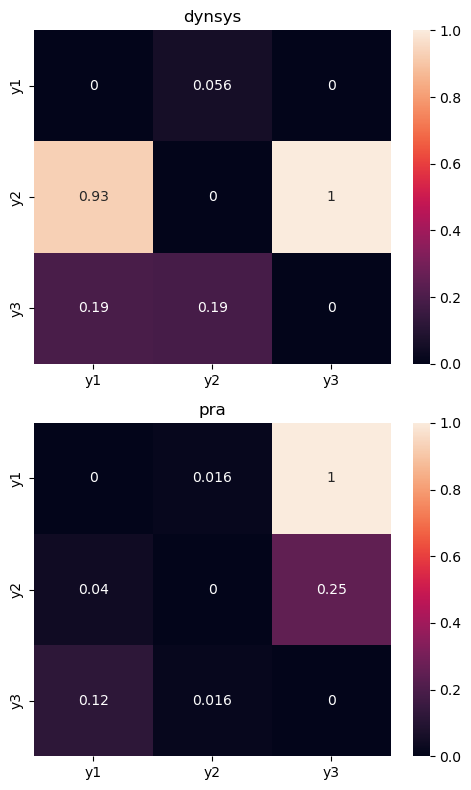

In [11]:
fig, (ax1,ax2) = plt.subplots(2,1,figsize=(5,8))
sns.heatmap(dynsys_mat.squeeze(), annot=True, xticklabels=['y1','y2','y3'], yticklabels=['y1','y2','y3'], ax=ax1)
ax1.set_title('dynsys')

sns.heatmap(pra_mat, annot=True, xticklabels=['y1','y2','y3'], yticklabels=['y1','y2','y3'], ax=ax2)
ax2.set_title('pra')

fig.tight_layout()
plt.savefig('heatmaps.png')

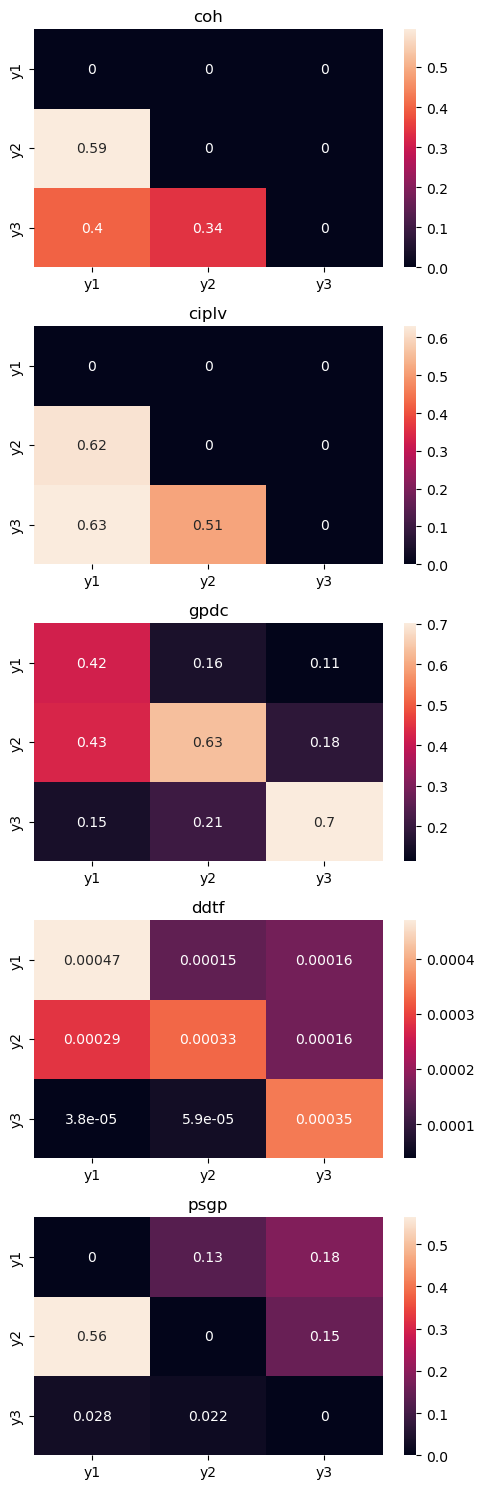

In [12]:
fig, (ax1,ax2,ax3,ax4,ax5) = plt.subplots(5,1,figsize=(5,15))
sns.heatmap(coh_mat.mean(2), annot=True, xticklabels=['y1','y2','y3'], yticklabels=['y1','y2','y3'], ax=ax1)
ax1.set_title('coh')

sns.heatmap(ciplv_mat.mean(2), annot=True, xticklabels=['y1','y2','y3'], yticklabels=['y1','y2','y3'], ax=ax2)
ax2.set_title('ciplv')

sns.heatmap(gpdc_mat.mean(2), annot=True, xticklabels=['y1','y2','y3'], yticklabels=['y1','y2','y3'], ax=ax3)
ax3.set_title('gpdc')

sns.heatmap(ddtf_mat.mean(2), annot=True, xticklabels=['y1','y2','y3'], yticklabels=['y1','y2','y3'], ax=ax4)
ax4.set_title('ddtf')

sns.heatmap(psgp_mat.mean(2), annot=True, xticklabels=['y1','y2','y3'], yticklabels=['y1','y2','y3'], ax=ax5)
ax5.set_title('psgp')
fig.tight_layout()
plt.savefig('heatmaps.png')